<a href="https://colab.research.google.com/github/babymlin/dog_cat_vgg16-99.24/blob/main/Transfor_Learning_dog_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [2]:
# data_set_url:"https://drive.google.com/file/d/1mAY0aJyMvc10jVzWJ9YhjKvETNxlwZ7u/view?usp=sharing"
!gdown --id 1mAY0aJyMvc10jVzWJ9YhjKvETNxlwZ7u --output train.zip

Downloading...
From: https://drive.google.com/uc?id=1mAY0aJyMvc10jVzWJ9YhjKvETNxlwZ7u
To: /content/train.zip
570MB [00:03, 170MB/s]


In [3]:
!unzip -q train.zip

In [4]:
from glob import glob
data = glob("train/*.*")
#print(data[:10])
class_name = {"cat":"1", "dog":"0"}
data_df = pd.DataFrame(columns=["path", "label"])
data_df["label"] = pd.Series([single.split("/")[-1].split(".")[0] for single in data])
data_df["path"] = pd.Series(data)
data_df["label"] = data_df["label"].apply(lambda x:class_name["cat"] if x=="cat" else class_name["dog"])
data_df

,path,label
0,train/dog.10694.jpg,0
1,train/cat.11915.jpg,1
2,train/dog.4214.jpg,0
3,train/dog.1140.jpg,0
4,train/dog.7814.jpg,0
...,...,...
24995,train/cat.9132.jpg,1
24996,train/dog.11184.jpg,0
24997,train/dog.3508.jpg,0
24998,train/cat.5773.jpg,1


In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
                        data_df["path"],
                        data_df["label"],
                        test_size=0.1,
                        random_state=1031
                      )
x_train.shape, y_train.shape, x_test.shape, y_test.shape, y_train.value_counts(), y_test.value_counts()

((22500,), (22500,), (2500,), (2500,), 0    11253
 1    11247
 Name: label, dtype: int64, 1    1253
 0    1247
 Name: label, dtype: int64)

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(
                        x_train,
                        y_train,
                        test_size=0.1,
                        random_state=1031
                      )
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, y_train.value_counts(), y_valid.value_counts()

((20250,), (20250,), (2250,), (2250,), 0    10134
 1    10116
 Name: label, dtype: int64, 1    1131
 0    1119
 Name: label, dtype: int64)

In [7]:
x_train_df = pd.concat([x_train, y_train], axis=1)
x_test_df = pd.concat([x_test, y_test], axis=1)
x_valid_df = pd.concat([x_valid, y_valid], axis=1)
x_train_df.shape, x_test_df.shape, x_valid_df.shape

((20250, 2), (2500, 2), (2250, 2))

In [8]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
           #horizontal_flip=True,
           #rotation_range=90,
           #zoom_range=[0.2, 0.2],
           preprocessing_function=preprocess_input
        )
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
img_size=(224, 224)
x_train_flow = train_gen.flow_from_dataframe(
            x_train_df,
            x_col="path",
            y_col="label",
            target_size=img_size,
          )
x_test_flow = test_gen.flow_from_dataframe(
            x_test_df,
            x_col="path",
            y_col="label",
            target_size=img_size,
            shuffle=False
          )
x_valid_flow = valid_gen.flow_from_dataframe(
            x_valid_df,
            x_col="path",
            y_col="label",
            target_size=img_size,
            shuffle=False
          )

Found 20250 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2250 validated image filenames belonging to 2 classes.


In [10]:
effb0 = EfficientNetB0(include_top=False, input_shape=(224, 224, 3))
effb0.trainable = False


16711680/16705208 [==============================] - 0s 0us/step


In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Softmax
input_layer = effb0.output
x = BatchNormalization()(input_layer)
x = GlobalAveragePooling2D()(x)
x = Dense(units=2)(x)
output_layer = Softmax()(x)
model = Model(inputs=effb0.input, outputs=output_layer)
#model.summary()

In [13]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
Radam = tfa.optimizers.RectifiedAdam(1e-2)
Ranger = tfa.optimizers.Lookahead(Radam)
model.compile(
    optimizer=Ranger,
    loss="CategoricalCrossentropy",
    metrics=["accuracy"]
)

     |████████████████████████████████| 686kB 30.7MB/s 


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
callbacks = [
    ModelCheckpoint("dog_cat_best.h5", monitor="val_loss", save_best_only=True),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    CSVLogger("logger.csv")
]

In [15]:
epochs = 100
batch_size = 64
model.fit(
    x_train_flow,
    epochs=epochs,
    #verbose=2,
    callbacks=callbacks,
    validation_data=(x_valid_flow),
    batch_size=batch_size
)

Epoch 1/100
633/633 [==============================] - 115s 126ms/step - loss: 0.0767 - accuracy: 0.9745 - val_loss: 0.0398 - val_accuracy: 0.9862


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
633/633 [==============================] - 79s 124ms/step - loss: 0.0432 - accuracy: 0.9850 - val_loss: 0.0531 - val_accuracy: 0.9844
Epoch 3/100
633/633 [==============================] - 78s 123ms/step - loss: 0.0436 - accuracy: 0.9851 - val_loss: 0.0519 - val_accuracy: 0.9867
Epoch 4/100
633/633 [==============================] - 78s 123ms/step - loss: 0.0426 - accuracy: 0.9859 - val_loss: 0.0527 - val_accuracy: 0.9853
Epoch 5/100
633/633 [==============================] - 78s 123ms/step - loss: 0.0419 - accuracy: 0.9867 - val_loss: 0.0589 - val_accuracy: 0.9871
Epoch 6/100
633/633 [==============================] - 78s 123ms/step - loss: 0.0433 - accuracy: 0.9869 - val_loss: 0.0619 - val_accuracy: 0.9889


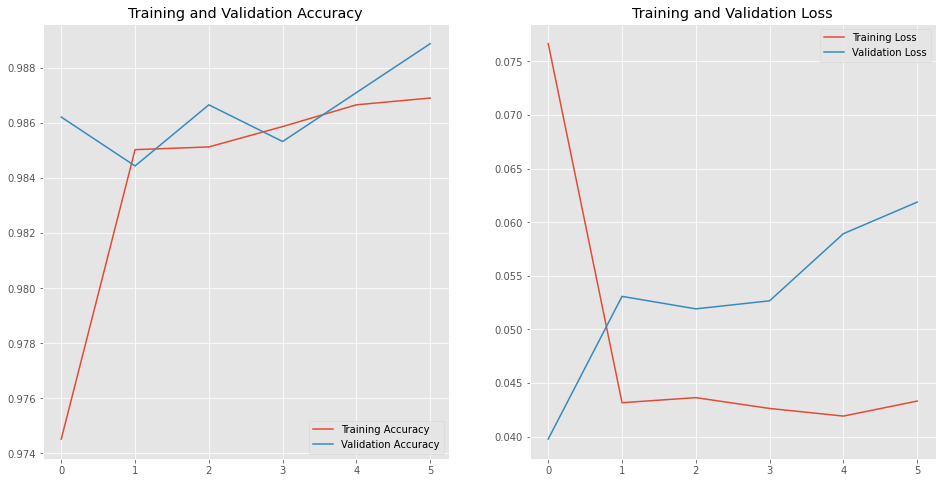

In [16]:
def plot_accuracy_loss(file_name):
    import pandas as pd
    log_data = pd.read_csv(file_name)
    acc = log_data['accuracy']
    val_acc = log_data['val_accuracy']
    loss = log_data['loss']
    val_loss = log_data['val_loss']
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(log_data['epoch'], acc, label='Training Accuracy')
    plt.plot(log_data['epoch'], val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(log_data['epoch'], loss, label='Training Loss')
    plt.plot(log_data['epoch'], val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt.show()
plot_accuracy_loss("logger.csv")

In [17]:
model.evaluate(x_test_flow)

79/79 [==============================] - 9s 115ms/step - loss: 0.0294 - accuracy: 0.9908


[0.02936589904129505, 0.9908000230789185]